In [1]:
import sys, os
sys.path.append('/cr/users/filip/bin/')

from utils.binaries import *
from utils.plotting import *

12:17:05 [INFO] utils          -- ( +2534ms) -- import logging
12:17:06 [INFO] utils.binaries -- (  +129ms) -- import numpy as np
12:17:06 [INFO] utils.binaries -- (    +7ms) -- import uncertainties
12:17:06 [INFO] utils.binaries -- (  +160ms) -- import pandas as pd
12:17:06 [INFO] utils.binaries -- (    +2ms) -- import binaries.tools as tools
12:17:06 [INFO] utils.plotting -- (  +563ms) -- import matplotlib.pyplot as plt
12:17:07 [INFO] utils.plotting -- (  +317ms) -- import seaborn as so
12:17:07 [DBUG] utils.plotting -- (    +7ms) -- font size set to 9.5
12:17:07 [DBUG] utils.plotting -- (    +1ms) -- label size set to 13.0
12:17:07 [DBUG] utils.plotting -- (    +1ms) -- figure size set to [6.6, 3.3]
12:17:07 [DBUG] utils.plotting -- (    +1ms) -- markersize set to 2.0
12:17:07 [DBUG] utils.plotting -- (    +1ms) -- usetex set to False
12:17:07 [INFO] utils.plotting -- (    +2ms) -- import plotting.tools as plot


In [10]:
date, station = 'Mar2023/', 'NadiaEarlyFilteredDownsampled/'
root_wcd = '/cr/tempdata01/filip/SSDCalib/UUBCrosscheck/'
root_ssd = f'/cr/tempdata01/filip/UubRandoms/{date}/converted/'

q_peak = {
    'NuriaJrFilteredDownsampled/' :      np.array([156.50, 163.65, 162.70]),
    'PeruFilteredDownsampled/' :         np.array([150.30, 117.50, 153.35]),
    'NadiaEarlyFilteredDownsampled/' :   np.array([148.90, 162.20, 151.75]),
    'NadiaLateFilteredDownsampled/' :    np.array([148.90, 162.20, 151.75]),
}

def get_latch_bin(wcd_trace):
    for bin, (b1, b2, b3) in enumerate(zip(*wcd_trace)):

        if b1 / q_peak[station][0] < 1.75: continue
        if b2 / q_peak[station][1] < 1.75: continue
        if b3 / q_peak[station][2] < 1.75: continue
        
        return bin * 3
    else: return -1


14:08:26 [DBUG] utils.plotting -- (+50826ms) -- font size set to 9.5
14:08:26 [DBUG] utils.plotting -- (    +2ms) -- label size set to 13.0
14:08:26 [DBUG] utils.plotting -- (    +2ms) -- figure size set to [3.3, 2.5]
14:08:26 [DBUG] utils.plotting -- (    +1ms) -- markersize set to 2.0
14:08:26 [DBUG] utils.plotting -- (    +1ms) -- usetex set to True


   1/632 // 0.16% || running: 01:51:13 // ETA: 1169:37:43 // 6673000ms/step
1620
528


StopIteration: 

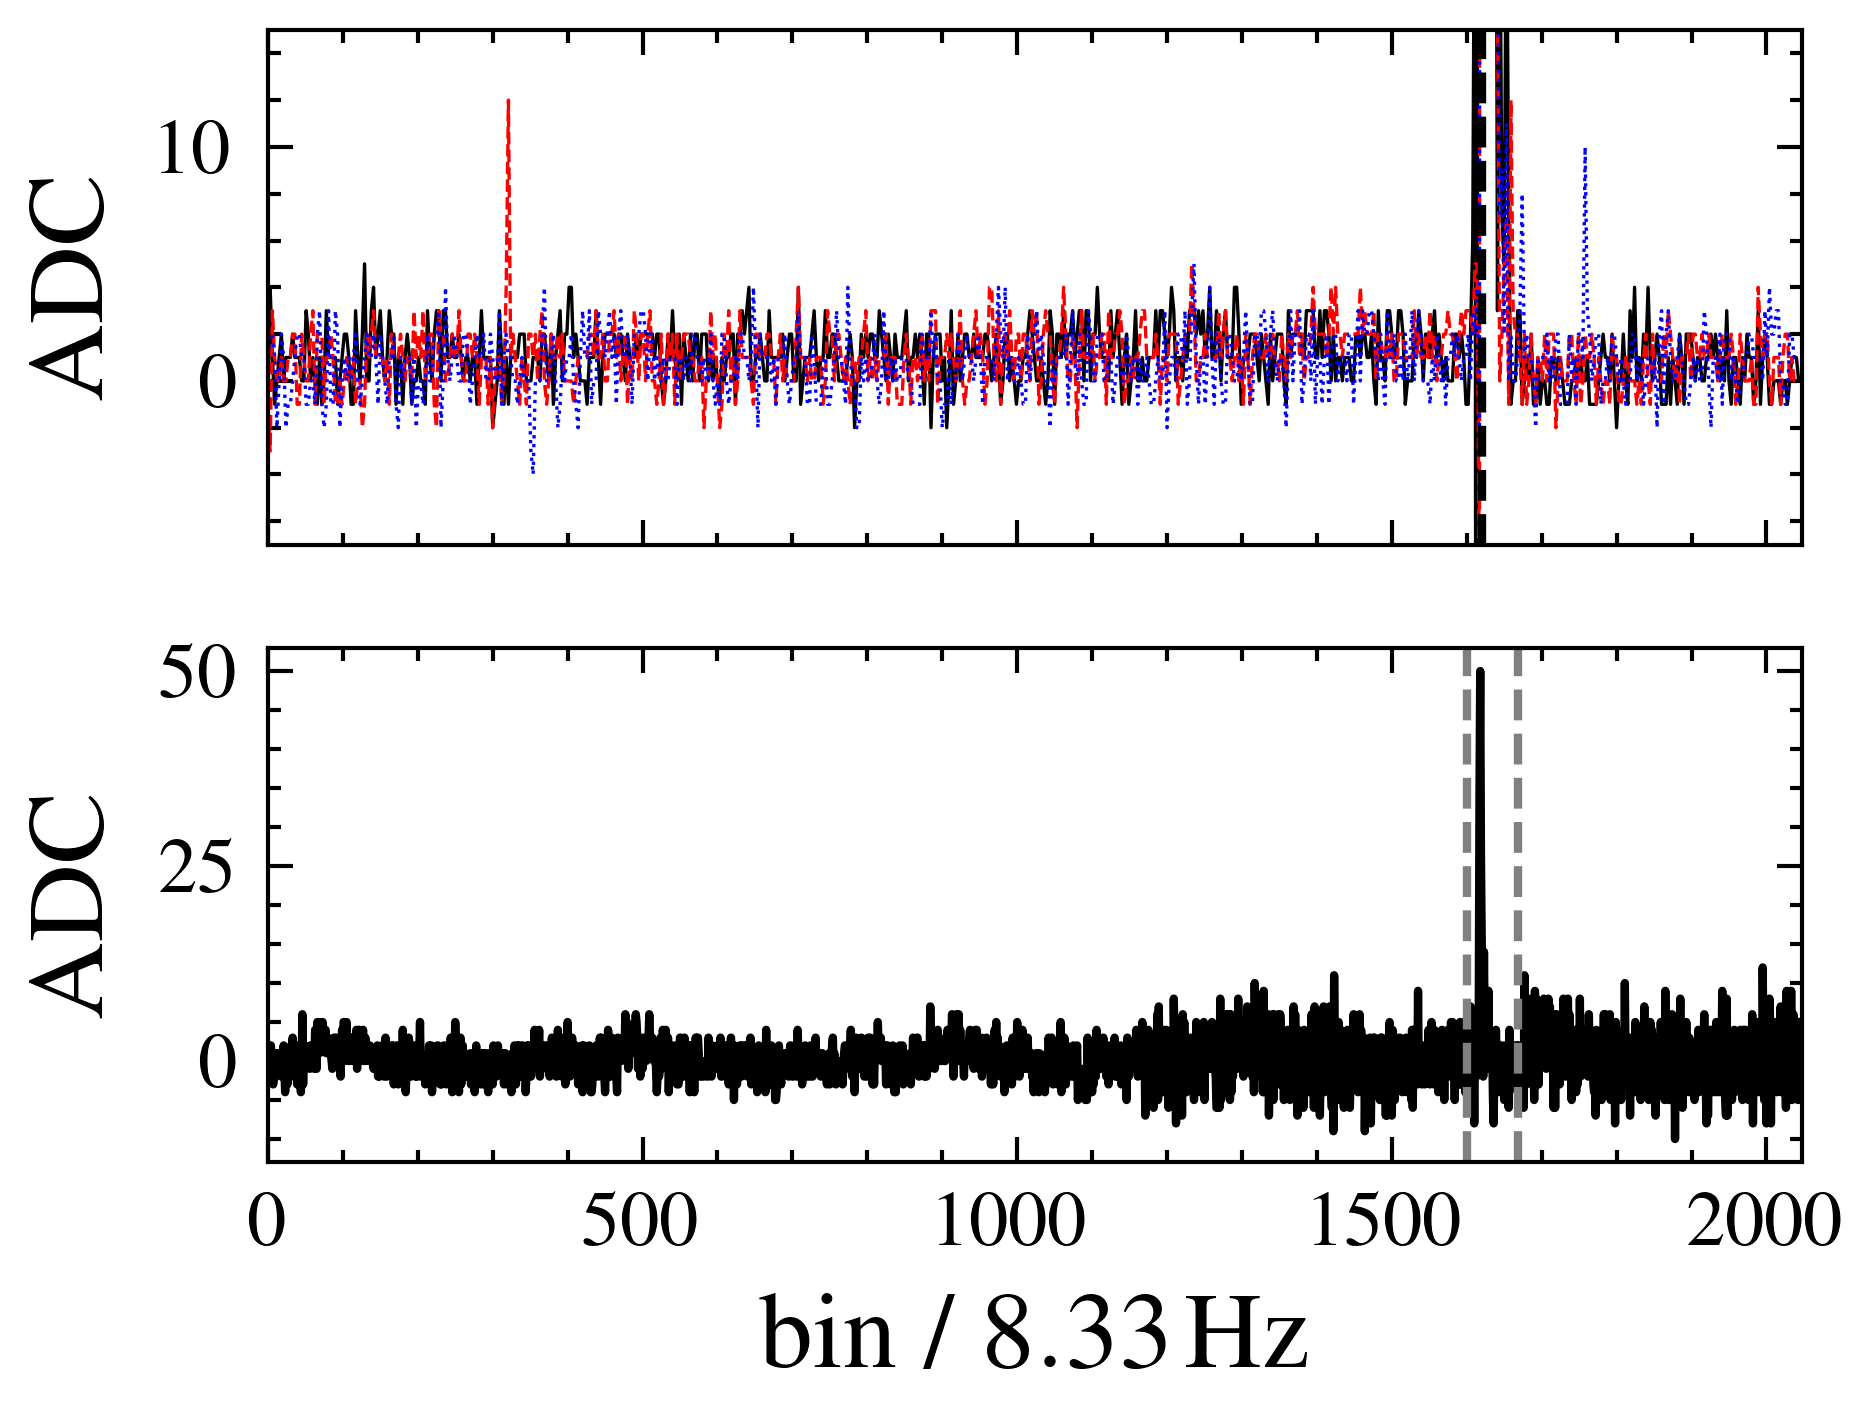

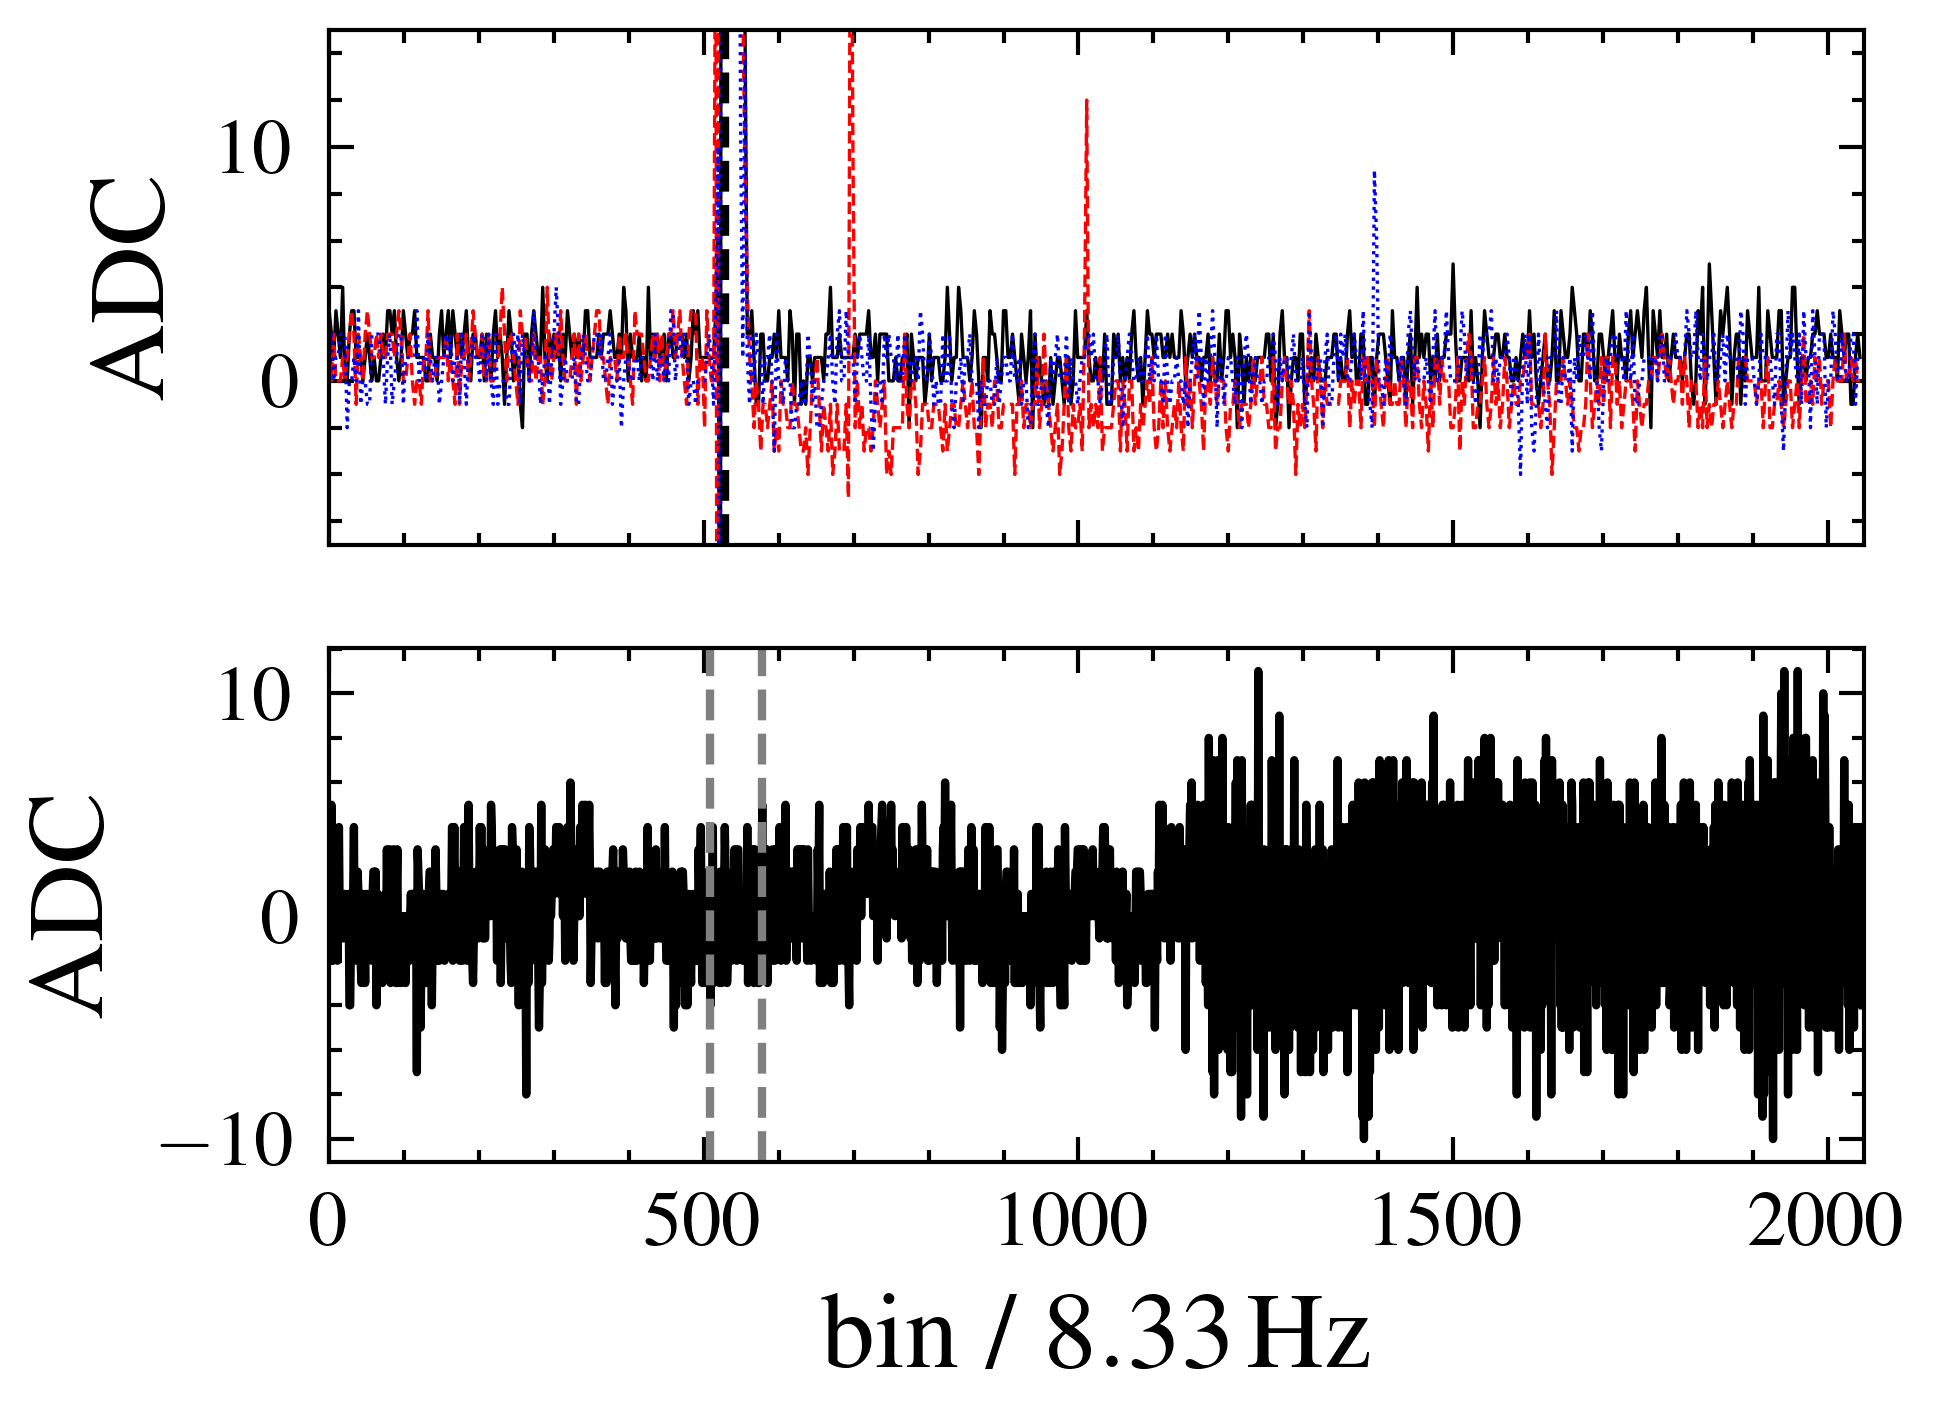

In [27]:
set_plt_style('double tex')
n_present_files, n_analyzed_files = len(os.listdir(root_ssd + station)) // 2, 0

have_misfit, have_fit = False, False

for i_file in range(n_present_files):
    tools.progress_bar(i_file, n_present_files)

    try:
        wcd_data = np.loadtxt(root_ssd + station + f'randoms{i_file:04}_WCD.dat')
        wcd_data = np.split(wcd_data, len(wcd_data) // 3)
        ssd_data = np.loadtxt(root_ssd + station + f'randoms{i_file:04}_SSD.dat')
        n_analyzed_files += 1
    except (FileNotFoundError, ValueError):
        continue

    for i_trace, (ssd, wcd) in enumerate(zip(ssd_data, wcd_data)):


        signal_in_window = False
        if have_misfit and have_fit: raise StopIteration
        if (latch_bin := get_latch_bin(wcd)) == -1: continue
        if latch_bin in [1611, 873, 150]: continue

        print(latch_bin)
        ssd_trace = ssd[1:] - ssd[0]
        ssd_trace_window = ssd_trace[np.max([latch_bin - 20, 0]) : np.min([latch_bin + 49, 2047])]

        if (ssd_max := int(np.max(ssd_trace_window))) < 3 * np.std(ssd_trace): 
            signal_in_window = True

        if signal_in_window and not have_fit:
            have_fit = True
            
            fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
            ax1.plot(range(0, 2046, 3), wcd[0], lw=0.4)
            ax1.plot(range(0, 2046, 3), wcd[1], lw=0.4)
            ax1.plot(range(0, 2046, 3), wcd[2], lw=0.4)
            # ax1.set_xlim(0, 2046)
            ax1.set_ylim(-7, 15)
            ax1.axvline(latch_bin, c="k", ls="--")
            ax2.set_xlabel("bin / $\SI{8.33}{\hertz}$")
            ax2.set_ylabel("ADC")
            ax1.set_ylabel("ADC")

            ax2.plot(range(2048), ssd_trace)
            ax2.set_xlim(0, 2048)
            ax2.axvline(np.max([latch_bin - 20, 0]), c='gray', ls="--")
            ax2.axvline(np.min([latch_bin + 49, 2047]), c='gray', ls="--")

        elif not signal_in_window and not have_misfit:
            have_misfit = True

            fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
            ax1.plot(range(0, 2046, 3), wcd[0], lw=0.4)
            ax1.plot(range(0, 2046, 3), wcd[1], lw=0.4)
            ax1.plot(range(0, 2046, 3), wcd[2], lw=0.4)
            # ax1.set_xlim(0, 2046)
            ax1.set_ylim(-7, 15)
            ax1.axvline(latch_bin, c="k", ls="--")
            
            ax2.set_xlabel("bin / $\SI{8.33}{\hertz}$")
            ax2.set_ylabel("ADC")
            ax1.set_ylabel("ADC")


            ax2.plot(range(2048), ssd_trace)
            ax2.set_xlim(0, 2048)
            ax2.axvline(np.max([latch_bin - 20, 0]), c='gray', ls="--")
            ax2.axvline(np.min([latch_bin + 49, 2047]), c='gray', ls="--")

        else: continue